[*********************100%***********************]  1 of 1 completed


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 20, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (Attention)         │ [(None, 64), (None,    │         4,224 │
│                                 │ 20)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,513 (95.75 KB)

 Trainable params: 24,513 (95.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0059 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0038 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010 - val_loss: 9.0945e-04 - learning_rate: 0.0010
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5869e-04 - val_loss: 7.8883e-04 - learning_rate: 0.0010
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4977e-04 - val_loss: 6.8863e-04 - learning_rate: 0.00

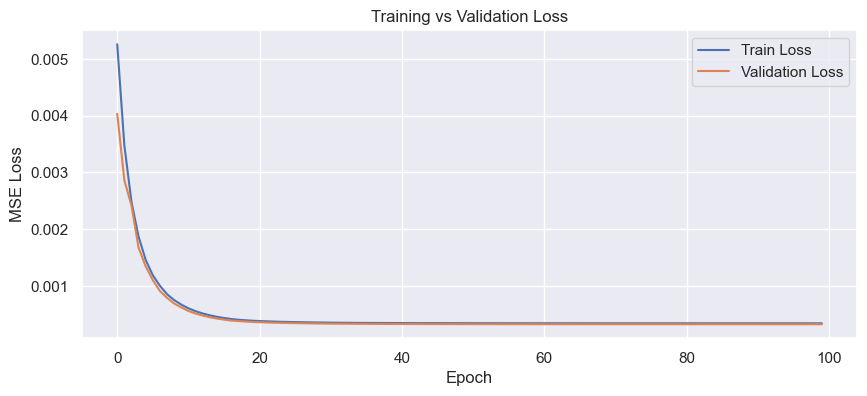

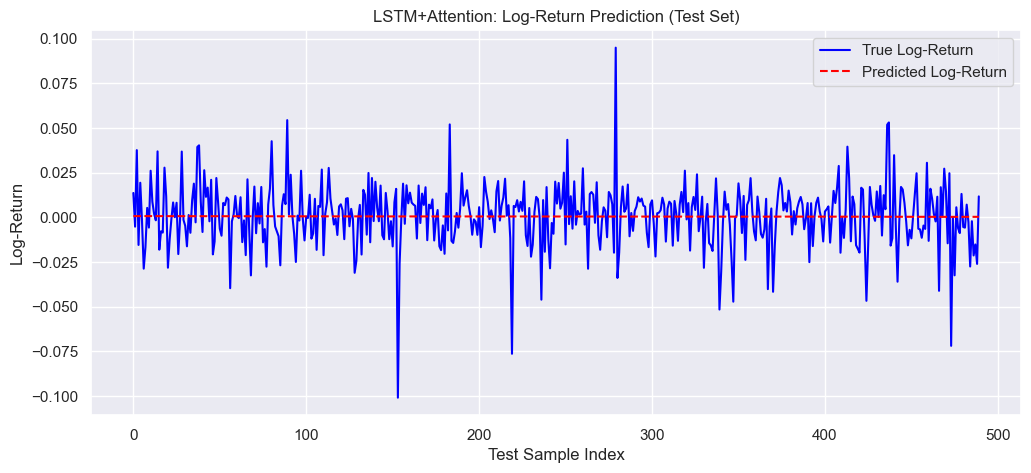


Model saved as 'lstm_attention_logreturn_model.h5'


In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# ----------------------------------------------------------
# 0. Configuration & Seeding
# ----------------------------------------------------------
sns.set()
tf.random.set_seed(1234)
np.random.seed(1234)

# ----------------------------------------------------------
# 1. Download and Prepare the Data
# ----------------------------------------------------------
symbol = 'GOOG'
start_date = '2015-01-01'
end_date = '2025-03-03'
df = yf.download(symbol, start=start_date, end=end_date)

# Select relevant columns and drop NaNs
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
df.dropna(inplace=True)

# Create log-close and daily log-returns
df['Close_Log'] = np.log(df['Close'])
df['LogReturn'] = df['Close_Log'].diff()  # daily log-return as our target

# Drop the first row with NaN in log-return
df.dropna(inplace=True)

# ----------------------------------------------------------
# 2. Feature Engineering
# ----------------------------------------------------------
# For example, add a simple 7-day moving average.
df['MA7'] = df['Close'].rolling(7).mean()
df.dropna(inplace=True)

# Define features and target column
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA7']
target_col = 'LogReturn'

# Convert to numpy arrays
feature_array = df[features].values
target_array = df[target_col].values.reshape(-1, 1)  # shape (n, 1)

# ----------------------------------------------------------
# 3. Train/Test Split (Time-Series)
# ----------------------------------------------------------
train_ratio = 0.8
train_size = int(len(df) * train_ratio)

train_features = feature_array[:train_size]
test_features  = feature_array[train_size:]
train_target   = target_array[:train_size]
test_target    = target_array[train_size:]

# ----------------------------------------------------------
# 4. Scale the Features (to prevent data leakage, fit on train only)
# ----------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_features)
scaled_train_features = scaler.transform(train_features)
scaled_test_features  = scaler.transform(test_features)

# ----------------------------------------------------------
# 5. Create Sequences for LSTM
# ----------------------------------------------------------
time_steps = 20

def create_sequences(features_scaled, target_vals, time_window=20):
    X_seq, y_seq = [], []
    for i in range(len(features_scaled) - time_window):
        X_seq.append(features_scaled[i : i + time_window])
        y_seq.append(target_vals[i + time_window])
    return np.array(X_seq), np.array(y_seq)

X_train, y_train = create_sequences(scaled_train_features, train_target, time_steps)
X_test,  y_test  = create_sequences(scaled_test_features,  test_target, time_steps)

# ----------------------------------------------------------
# 6. Build a Simple LSTM Model with Attention
# ----------------------------------------------------------
class Attention(tf.keras.layers.Layer):
    """
    Custom Attention layer returning weighted context vector and attention weights.
    """
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name='att_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='random_normal',
            trainable=True
        )
        self.b = self.add_weight(
            name='att_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='att_u',
            shape=(input_shape[-1],),
            initializer='random_normal',
            trainable=True
        )
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, features)
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)  # (batch_size, time_steps, features)
        vu = tf.tensordot(v, self.u, axes=1)                         # (batch_size, time_steps)
        alphas = tf.nn.softmax(vu)                                   # (batch_size, time_steps)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output, alphas

def build_lstm_attention_model(time_steps, num_features, lr=1e-3):
    inputs = Input(shape=(time_steps, num_features))
    x = LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = Dropout(0.2)(x)
    attention_out, _ = Attention()(x)
    x = Dropout(0.2)(attention_out)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    outputs = Dense(1)(x)  # Predicting LogReturn

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse'
    )
    return model

model = build_lstm_attention_model(time_steps, X_train.shape[-1], lr=1e-3)
model.summary()

# ----------------------------------------------------------
# 7. Train the Model
# ----------------------------------------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# ----------------------------------------------------------
# 8. Evaluate the Model on the Test Set
# ----------------------------------------------------------
preds = model.predict(X_test).ravel()  # shape: (num_samples,)
mse_val  = mean_squared_error(y_test, preds)
rmse_val = np.sqrt(mse_val)
mae_val  = mean_absolute_error(y_test, preds)

print("\n[Model Evaluation on Log-Return]")
print(f"MAE:  {mae_val:.4f}")
print(f"MSE:  {mse_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")

# ----------------------------------------------------------
# 9. Compare with a Naive Baseline (Predict Yesterday's Log-Return)
# ----------------------------------------------------------
# Convert y_test to a flat (1D) array so that each element is a scalar.
y_test_flat = y_test.flatten()

# Use the previous day's log-return as prediction.
naive_preds = np.empty_like(y_test_flat)
naive_preds[0] = 0.0  # For the first sample, assign 0.0 (or use y_train[-1] if desired)
naive_preds[1:] = y_test_flat[:-1]

mse_naive  = mean_squared_error(y_test_flat, naive_preds)
rmse_naive = np.sqrt(mse_naive)
mae_naive  = mean_absolute_error(y_test_flat, naive_preds)

print("\n[Naive Baseline: Predict Yesterday's Log-Return]")
print(f"MAE:  {mae_naive:.4f}")
print(f"MSE:  {mse_naive:.4f}")
print(f"RMSE: {rmse_naive:.4f}")

# ----------------------------------------------------------
# 10. Visualization
# ----------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(y_test_flat)), y_test_flat, label='True Log-Return', color='blue')
plt.plot(np.arange(len(preds)), preds, label='Predicted Log-Return', color='red', linestyle='--')
plt.title("LSTM+Attention: Log-Return Prediction (Test Set)")
plt.xlabel("Test Sample Index")
plt.ylabel("Log-Return")
plt.legend()
plt.show()

# ----------------------------------------------------------
# 11. Save the Model (Optional)
# ----------------------------------------------------------
model.save("lstm_attention_logreturn_model.h5")
print("\nModel saved as 'lstm_attention_logreturn_model.h5'")
